In [1]:
!nvidia-smi

Fri May  6 11:52:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install segmentation_models
# for str decode error ... run it and restart runtime
# !pip uninstall h5py
# !pip install h5py==2.10.0

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import cv2 
import numpy as np
from tqdm import tqdm

In [4]:
train_masks = sorted(glob('../input/multiclass-face-segmentation/content/All_data/train/seg/*'))
val_masks = sorted(glob('../input/multiclass-face-segmentation/content/All_data/val/seg/*'))
total = train_masks + val_masks
len(train_masks), len(val_masks), len(total)

(19535, 2653, 22188)

In [5]:
total[19530:19540]

['../input/multiclass-face-segmentation/content/All_data/train/seg/2090_0006.png',
 '../input/multiclass-face-segmentation/content/All_data/train/seg/2090_0007.png',
 '../input/multiclass-face-segmentation/content/All_data/train/seg/2090_0008.png',
 '../input/multiclass-face-segmentation/content/All_data/train/seg/2090_0009.png',
 '../input/multiclass-face-segmentation/content/All_data/train/seg/2090_0010.png',
 '../input/multiclass-face-segmentation/content/All_data/val/seg/0015_0001.png',
 '../input/multiclass-face-segmentation/content/All_data/val/seg/0015_0002.png',
 '../input/multiclass-face-segmentation/content/All_data/val/seg/0015_0003.png',
 '../input/multiclass-face-segmentation/content/All_data/val/seg/0015_0004.png',
 '../input/multiclass-face-segmentation/content/All_data/val/seg/0015_0005.png']

In [6]:
# for i in tqdm(total):
#   # print(i)
#   img = cv2.imread(i,0)

#   for j in [11, 12]:
#     img = np.where(img== j, 1, img)

#   for j in [10, 15, 17]:
#     img = np.where(img== j, 0, img)

#   # print(np.unique(img))
#   # plt.imshow(img, cmap = 'gray')
#   # plt.show()
#   # break
#   img = cv2.resize(img, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)

#   cv2.imwrite(i, img)

In [7]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, MaxPooling2D
from keras.layers import AveragePooling2D, Concatenate, Input, GlobalAveragePooling2D
from keras.models import Model


def SqueezeNet(input_shape):

    def Fire(inputs, fs, fe):

      s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
      s1 = BatchNormalization()(s1)
      e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
      e1 = BatchNormalization()(e1)
      e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
      e3 = BatchNormalization()(e3)

      output = Concatenate()([e1, e3])

      return output


    x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(input_shape)
    x1= s1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

    f2 = Fire(x1, 16, 64)
    f3 = Fire(f2, 16, 64)
    f4 = Fire(f3, 32, 128)
    x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

    f5 = Fire(x1, 32, 128)
    f6 = Fire(f5, 48, 192)
    f7 = Fire(f6, 48, 192)
    f8 = Fire(f7, 64, 256)
    x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

    f8 = Fire(x1, 64, 256)

    return f4, f8


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=128, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y

def DeepLabV3Plus(inputs, classes=1):

    inputs = Input(inputs)

    low_level_image_features, high_level_image_features = SqueezeNet(input_shape = inputs)

    x_a = ASPP(high_level_image_features)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    x_b = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    x = Conv2D(classes, (1, 1), name='output_layer')(x)
    
    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

# model = DeepLabV3Plus(inputs=(512,512,3), classes=1)
# model.summary()


In [8]:
train_imgs = sorted(glob('../input/multiclass-face-segmentation/content/All_data/train/image/*'))
val_imgs = sorted(glob('../input/multiclass-face-segmentation/content/All_data/val/image/*'))
total_imgs = train_imgs + val_imgs
len(train_imgs), len(val_imgs), len(total_imgs)

(19535, 2653, 22188)

In [9]:
train_masks = sorted(glob('../input/multiclass-face-segmentation/content/All_data/train/seg/*'))
val_masks = sorted(glob('../input/multiclass-face-segmentation/content/All_data/val/seg/*'))
total_masks = train_masks + val_masks
len(train_masks), len(val_masks), len(total_masks)

(19535, 2653, 22188)

In [19]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(images, masks):
    
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.35, random_state=1996, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1996, shuffle=True)
    
    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(sorted(total_imgs), sorted(total_masks))
train_x, val_x, train_y, val_y = train_x[:3500], val_x[:500], train_y[:3500], val_y[:500]
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))

def shuffle(samples):
  index = np.random.permutation(len(samples))
  return np.array(samples)[index]

def get_data_generator(samples,batch_size):

  while True:
    for offset in range(0, len(samples), batch_size): 
      samples = shuffle(samples)           
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      Y_train = []        
 
      for batch_sample in batch_samples:
          
#         print(batch_sample)

        X_image = cv2.imread(batch_sample[0])[:,:,::-1]# convert bgr to rgb
        X_image = cv2.resize(X_image, (256, 256))
        # X_image = np.dstack((X_image, X_image, X_image))
        X_image = X_image / 255.0
        X_image = X_image.astype(np.float32)
        # X_image = np.expand_dims(X_image, axis=-1)
        
        Y_image = cv2.imread(batch_sample[1], 0)
        
        Y_image = np.where(Y_image== 3, 2, Y_image)
        Y_image = np.where(Y_image== 14, 13, Y_image)
        for j in [9, 8]:
            Y_image = np.where(Y_image== j, 7, Y_image)
        for j in [4, 5]:
            Y_image = np.where(Y_image== j, 3, Y_image)
        for j in [11, 12]:
            Y_image = np.where(Y_image== j, 1, Y_image)
        for j in [10, 15, 17]:
            Y_image = np.where(Y_image== j, 0, Y_image)
#         print(np.unique(Y_image))
        
        Y_image = cv2.resize(Y_image, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
        Y_image = tf.one_hot(Y_image, 8, dtype = np.float32)
        Y_image = np.array(Y_image)
#         Y_image = Y_image.astype(np.float32)
        # Y_image = np.expand_dims(Y_image, axis=-1)

        X_train.append(X_image)
        Y_train.append(Y_image)
 
      yield np.array(X_train), np.array(Y_train)


BATCH_SIZE = 64
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

3500 500 3500 500 7766 7766
(64, 256, 256, 3) (64, 256, 256, 8)
(64, 256, 256, 3) (64, 256, 256, 8)
(64, 256, 256, 3) (64, 256, 256, 8)


In [18]:
np.unique(next(train_generator)[1])

array([0., 1.], dtype=float32)

In [12]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from keras import backend as K 
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Paramaters """
input_shape = (256, 256, 3)
epochs = 1000
lr = 1e-2
csv_path = "./history.csv"

""" callbacks """
checkpoint_filepath = './Deeplabv3p_SQNet_Face_Seg_00{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    verbose = 1,
    period = 1,
    save_best_only=True
    )
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=8)
]

""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print('train_steps: ', train_steps, '\nval_steps: ', val_steps)


""" Model training """
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

K.clear_session()
model = DeepLabV3Plus(inputs=input_shape, classes=8)
# model.load_weights('./Deeplabv3pSE_EffB0_Face_Seg_0019.h5')
# model.summary()

# for layer in model.layers:
#   if layer.name == "global_average_pooling2d_1":
#     break
#   else:
#     layer.trainable = False
# for layer in model.layers:
#   print(layer.name,layer.trainable)
# break
model.compile(
    loss=ls,
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=metrics
)


h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    workers=-1,
    use_multiprocessing=True,
    batch_size=BATCH_SIZE,
)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
55 8
Epoch 1/1000
55/55 [==============================] - 348s 6s/step - loss: 1.7326 - precision: 0.1872 - recall: 0.4412 - f1-score: 0.1842 - iou_score: 0.1493 - val_loss: 1.5059 - val_precision: 0.9846 - val_recall: 0.3750 - val_f1-score: 0.3669 - val_iou_score: 0.3598

Epoch 00001: val_iou_score improved from -inf to 0.35983, saving model to ./Deeplabv3p_SQNet_Face_Seg_001.h5
Epoch 2/1000
55/55 [==============================] - 324s 6s/step - loss: 1.5885 - precision: 0.2583 - recall: 0.5156 - f1-score: 0.2578 - iou_score: 0.1988 - val_loss: 2.2466 - val_precision: 0.1547 - val_recall: 0.4704 - val_f1-score: 0.1250 - val_iou_score: 0.1052

Epoch 00002: val_iou_score did not improve from 0.35983
Epoch 3/1000
55/55 [==============================] - 318s 6s/step - loss: 1.4224 - precision: 0.3591 - recall: 0.6119 - f1-score: 0.3547 - iou_score: 0.2645 - val_loss: 2.6428 - val_precision: 0.1355 - val_recall:

dict_keys(['loss', 'precision', 'recall', 'f1-score', 'iou_score', 'val_loss', 'val_precision', 'val_recall', 'val_f1-score', 'val_iou_score', 'lr']) 



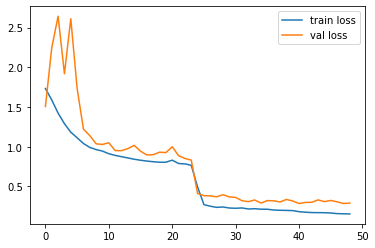

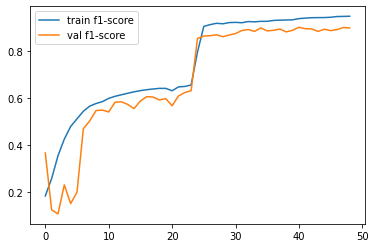

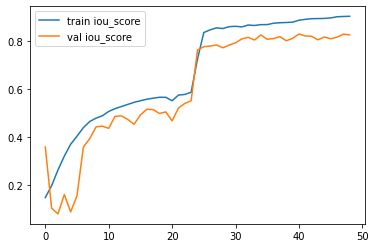

<Figure size 432x288 with 0 Axes>

In [13]:
print(h.history.keys(),"\n")

import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss')

plt.plot(h.history['f1-score'], label='train f1-score')
plt.plot(h.history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()
plt.savefig('f1-score')

plt.plot(h.history['iou_score'], label='train iou_score')
plt.plot(h.history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()
plt.savefig('iou_score')

In [14]:
model.save('./Deeplabv3p_SQNet_Face_Seg_last.h5')

In [15]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
print(test_steps)    

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

122
122/122 [==============================] - 536s 4s/step - loss: 0.2819 - precision: 0.9139 - recall: 0.8894 - f1-score: 0.9008 - iou_score: 0.8310


[0.28187987208366394,
 0.9139212965965271,
 0.8894056081771851,
 0.9008122682571411,
 0.8310468196868896]

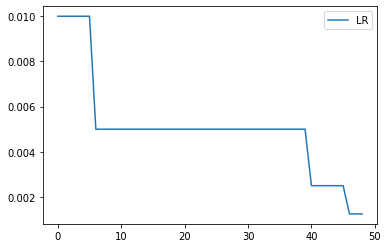

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(h.history['lr'], label='LR')
# plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LR')

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(images, masks):
    
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.35, random_state=1996, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1996, shuffle=True)
    
    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(sorted(total_imgs), sorted(total_masks))
# train_x, val_x, train_y, val_y = train_x[:3500], val_x[:500], train_y[:3500], val_y[:500]
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))

def shuffle(samples):
  index = np.random.permutation(len(samples))
  return np.array(samples)[index]

def get_data_generator(samples,batch_size):

  while True:
    for offset in range(0, len(samples), batch_size): 
      samples = shuffle(samples)           
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      Y_train = []        
 
      for batch_sample in batch_samples:
          
#         print(batch_sample)

        X_image = cv2.imread(batch_sample[0])[:,:,::-1]# convert bgr to rgb
        X_image = cv2.resize(X_image, (256, 256))
        # X_image = np.dstack((X_image, X_image, X_image))
        X_image = X_image / 255.0
        X_image = X_image.astype(np.float32)
        # X_image = np.expand_dims(X_image, axis=-1)
        
        Y_image = cv2.imread(batch_sample[1], 0)
        
        Y_image = np.where(Y_image== 3, 2, Y_image)
        Y_image = np.where(Y_image== 14, 13, Y_image)
        for j in [9, 8]:
            Y_image = np.where(Y_image== j, 7, Y_image)
        for j in [4, 5]:
            Y_image = np.where(Y_image== j, 3, Y_image)
        for j in [11, 12]:
            Y_image = np.where(Y_image== j, 1, Y_image)
        for j in [10, 15, 17]:
            Y_image = np.where(Y_image== j, 0, Y_image)
#         print(np.unique(Y_image))
        
        Y_image = cv2.resize(Y_image, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
        Y_image = tf.one_hot(Y_image, 8, dtype = np.float32)
        Y_image = np.array(Y_image)
#         Y_image = Y_image.astype(np.float32)
        # Y_image = np.expand_dims(Y_image, axis=-1)

        X_train.append(X_image)
        Y_train.append(Y_image)
 
      yield np.array(X_train), np.array(Y_train)


BATCH_SIZE = 64
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

11537 2885 11537 2885 7766 7766


In [ ]:
np.unique(next(train_generator)[1])

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from keras import backend as K 
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Paramaters """
input_shape = (256, 256, 3)
epochs = 1000
lr = 1e-2
csv_path = "./history2.csv"

""" callbacks """
checkpoint_filepath = './Deeplabv3p_SQNet_Face_Seg_049{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    verbose = 1,
    period = 1,
    save_best_only=True
    )
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=8)
]

""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print(train_steps, val_steps)


""" Model training """
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

K.clear_session()
model = DeepLabV3Plus(inputs=input_shape, classes=8)
model.load_weights('./Deeplabv3p_SQNet_Face_Seg_last.h5')
# model.summary()

# for layer in model.layers:
#   if layer.name == "global_average_pooling2d_1":
#     break
#   else:
#     layer.trainable = False
# for layer in model.layers:
#   print(layer.name,layer.trainable)
# break
model.compile(
    loss=ls,
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=metrics
)


h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    workers=-1,
    use_multiprocessing=True,
    batch_size=BATCH_SIZE,
    initial_epoch = 49,
)